In [1]:
import itertools
from copy import deepcopy

import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt
import pandas as pd


from model import BaseModel
from true_causal_model import TrueCausalModel
from agents.causal_agents import HalfBlindAgent

%matplotlib inline
np.random.seed(0)

## Genero creencias p<sub>ij</sub>

In [21]:
variables = sorted(["Tratamiento", "Reaccion", "Enfermedad", "Final"])
invalid_edges = sorted([("Enfermedad", "Tratamiento")])
k = 2
connection_tables = dict()
for pair in itertools.combinations((variables), 2):
    if pair in invalid_edges:
        continue
    alpha_value = np.random.rand(k)
    table = np.squeeze(dirichlet.rvs(alpha_value, size=1))
    connection_tables["{}->{}".format(pair[0], pair[1])] = table
ebunch = []
for pair in connection_tables:
    r = np.random.rand()
    prob_connection = connection_tables[pair][0]
    var_one = pair.split("->")[0]
    var_two = pair.split("->")[1]
    print("+-----------------------------------+")
    print("P({0} -> {1}) = {2:.3f}".format(var_one, var_two, prob_connection))
    print("P({0} -> {1}) = {2:.3f}".format(var_two, var_one, 1 - prob_connection))
    print("+-----------------------------------+")
    if r < prob_connection:
        ebunch.append([var_one, var_two])
    else:
        ebunch.append([var_two, var_one])

+-----------------------------------+
P(Enfermedad -> Final) = 0.990
P(Final -> Enfermedad) = 0.010
+-----------------------------------+
+-----------------------------------+
P(Enfermedad -> Reaccion) = 0.000
P(Reaccion -> Enfermedad) = 1.000
+-----------------------------------+
+-----------------------------------+
P(Final -> Reaccion) = 0.000
P(Reaccion -> Final) = 1.000
+-----------------------------------+
+-----------------------------------+
P(Final -> Tratamiento) = 0.002
P(Tratamiento -> Final) = 0.998
+-----------------------------------+
+-----------------------------------+
P(Reaccion -> Tratamiento) = 0.801
P(Tratamiento -> Reaccion) = 0.199
+-----------------------------------+


## Genero grafo aleatorio e inicializo PGM

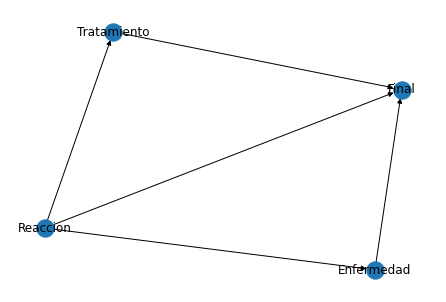

<Figure size 432x288 with 0 Axes>

In [23]:
complete_model = BaseModel('configs/model_parameters.json')
nature = TrueCausalModel(complete_model)
unknown_model = deepcopy(complete_model)
unknown_model.init_graph(ebunch, plot=True)
unknown_model.ebunch = ebunch
unknown_model.pgmodel = BayesianModel(ebunch)

## Estructura real

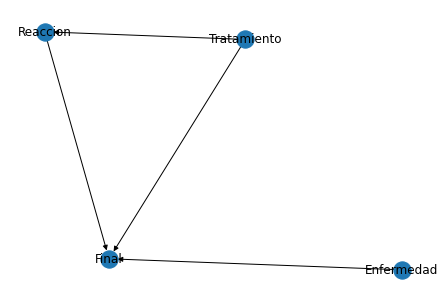

<Figure size 432x288 with 0 Axes>

In [11]:
complete_model.save_digraph_as_img("figures/gt_graph")

## El agente selecciona una acción con el modelo aproximado

In [12]:
agent = HalfBlindAgent(nature, unknown_model)
intervention_vars = agent.model.get_intervention_variables()
target_value = 1
target = {
    "variable": agent.model.get_target_variable(),
    "value" : target_value
}
best_actions = agent.make_decision(target, intervention_vars)
print("Best value for {} = {}".format(intervention_vars[0], best_actions[0]))

Best value for Tratamiento = 1


##  El agente observa y actualiza tablas de probabilidad condicional

In [13]:
nature_response = agent.nature.action_simulator(intervention_vars, best_actions)
agent.rewards_per_round.append(nature_response[target["variable"]])
agent.update_beliefs(nature_response)
agent.update_cpts_causal_model()
for var in nature_response:
    print("{} = {}".format(var, nature_response[var]))

Enfermedad = 0
Tratamiento = 1
Reaccion = 1
Final = 1


## Checo diferencia entre le modelo real y el aproximado

### Probabilidad de observación dado el modelo real

In [14]:
print(complete_model.get_joint_prob_observation(nature_response))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0.21


### Probabilidad de observación dado el modelo aproximado

In [15]:
print(agent.model.get_joint_prob_observation(nature_response))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0.23419873003653266


## Actualizar una prob arista (P<sub>Reacción->Tratamiento</sub>)

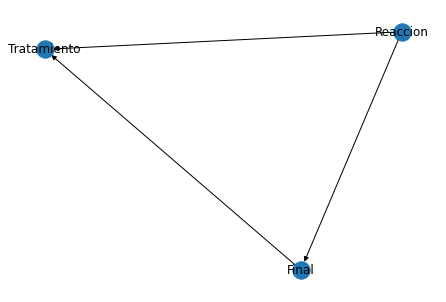

In [30]:
aux_model = deepcopy(agent.model)
aux_model.pgmodel.remove_nodes_from(["Enfermedad"])
aux_model.infer_system = VariableElimination(aux_model.pgmodel)
nx.draw(aux_model.pgmodel, with_labels=True)
plt.show()

### Prob de observación en el subgrafo

In [32]:
p_sub = aux_model.get_joint_prob_observation(nature_response)
print(p_sub)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0.19375142461327613


### Nuevo valor para p

In [34]:
p = p_sub * connection_tables["Reaccion->Tratamiento"][0]
print("P(Reaccion -> Tratamiento) = {0:.3f}".format(p))
print("P(Tratamiento -> Reaccion) = {0:.3f}".format(1 - p))

P(Reaccion -> Tratamiento) = 0.155
P(Tratamiento -> Reaccion) = 0.845
